In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits,ascii
import pandas as pd
import cmasher as cmr
from kinemetry import kinemetry
from kinemetry_plots import clean_images

In [2]:
gas_file = "MAGPI_Emission_Lines/MAGPI1201/MAGPI1201_v2.2.1_GIST_EmissionLine_Maps/MAGPI1201302222_GIST_EmissionLines.fits"
try:
    gasfile = fits.open(gas_file)
    g_flux, g_flux_err, g_velo, g_velo_err, g_sigma, g_sigma_err = gasfile[49].data, gasfile[50].data,gasfile[9].data, gasfile[10].data, gasfile[11].data, gasfile[12].data
    gasfile.close()
except IOError:
    pass
star_file = "MAGPI_Absorption_Lines/MAGPI1201/galaxies/1201302222_kinematics_ppxf-maps.fits"
starfile = fits.open(star_file)
s_flux, s_velo, s_velo_err, s_sigma = starfile[7].data, starfile[1].data, starfile[3].data, starfile[4].data
starfile.close()
file = pd.read_csv("MAGPI_csv/MAGPI_kinemetry_sample_source_catalogue.csv")
file = file[file["MAGPIID"].isin([1201302222])]
z = file["z"].to_numpy()[0]
pa = file["ang_it"].to_numpy()[0]
q = file["axrat_it"].to_numpy()[0]
re = file["R50_it"].to_numpy()[0] / 0.2
quality = file["QOP"].to_numpy()[0]
galaxy = file["MAGPIID"].to_numpy()[0]
start = (0.65/2)/0.2
step = (0.65/2)/0.2
end = 2*re
rad = np.arange(start,end,step)
y0,x0 = g_flux.shape
y0,x0 = y0/2,x0/2

In [3]:
g_velo = clean_images(g_velo, pa, re, re * q, img_err=g_flux / g_flux_err)
g_velo_err = clean_images(g_velo_err, pa, re, re* q, img_err=g_flux / g_flux_err)
g_flux = clean_images(g_flux, pa, re, re * q, img_err=g_flux / g_flux_err)
g_flux = g_flux / g_flux_err
g_velo[np.isnan(g_velo)] = 0
g_sigma[np.isnan(g_sigma)] = 0
g_velo_err[np.isnan(g_velo_err)] = 0
g_flux[np.isnan(g_flux)] = 0
s_velo[np.isnan(s_velo)] = 0
s_sigma[np.isnan(s_sigma)] = 0
s_velo_err[np.isnan(s_velo_err)] = 0
s_flux[np.isnan(s_flux)] = 0

In [4]:
kg_velo = kinemetry(img=g_velo, x0=x0, y0=y0, ntrm=11, plot=False, verbose=False, radius=rad,bmodel=True, rangePA=[0, 360], rangeQ=[q - 0.1, q + 0.1], allterms=True)
ks_velo = kinemetry(img=s_velo, x0=x0, y0=y0, ntrm=11, plot=False, verbose=False, radius=rad,bmodel=True, rangePA=[0, 360], rangeQ=[q - 0.1, q + 0.1], allterms=True)
kg_sigma = kinemetry(img=g_sigma, x0=x0, y0=y0, ntrm=10, plot=False, verbose=False, radius=rad,bmodel=True, rangePA=[0, 360], rangeQ=[q - 0.1, q + 0.1], even=True)
ks_sigma = kinemetry(img=s_sigma, x0=x0, y0=y0, ntrm=10, plot=False, verbose=False, radius=rad,bmodel=True, rangePA=[0, 360], rangeQ=[q - 0.1, q + 0.1], even=True)

In [5]:
ks1 = np.sqrt(ks_velo.cf[:, 1] ** 2 + ks_velo.cf[:, 2] ** 2)
ks2 = np.sqrt(ks_velo.cf[:, 3] ** 2 + ks_velo.cf[:, 4] ** 2)
ks3 = np.sqrt(ks_velo.cf[:, 5] ** 2 + ks_velo.cf[:, 6] ** 2)
ks4 = np.sqrt(ks_velo.cf[:, 6] ** 2 + ks_velo.cf[:, 7] ** 2)
ks5 = np.sqrt(ks_velo.cf[:, 8] ** 2 + ks_velo.cf[:, 10] ** 2)
v_asym_s = (ks2 + ks3 + ks4 + ks5) / (4 * ks1)
print(v_asym_s)
kg1 = np.sqrt(kg_velo.cf[:, 1] ** 2 + kg_velo.cf[:, 2] ** 2)
kg2 = np.sqrt(kg_velo.cf[:, 3] ** 2 + kg_velo.cf[:, 4] ** 2)
kg3 = np.sqrt(kg_velo.cf[:, 5] ** 2 + kg_velo.cf[:, 6] ** 2)
kg4 = np.sqrt(kg_velo.cf[:, 6] ** 2 + kg_velo.cf[:, 7] ** 2)
kg5 = np.sqrt(kg_velo.cf[:, 8] ** 2 + kg_velo.cf[:, 10] ** 2)
v_asym_g = (kg2 + kg3 + kg4 + kg5) / (4 * kg1)
print(v_asym_g)

[1.23703959 0.59439813 0.82013664        nan        nan]
[0.04553575 0.06116627 0.0681022  0.07701427 0.08602684]


/var/folders/nl/v2f_l95j0jx701ctszdv_thr0000gp/T/ipykernel_79234/1521442390.py:6: RuntimeWarning: invalid value encountered in divide
  v_asym_s = (ks2 + ks3 + ks4 + ks5) / (4 * ks1)


In [6]:
print(v_asym_g)
s = np.median(kg_sigma.cf[:,0])
v = np.median(np.sqrt(kg_velo.cf[:,1]**2 + kg_velo.cf[:,2]**2))
g_s05 = 4*(np.sqrt(0.5*v**2 + s**2))
v_asym_g_new = (kg2+kg3+kg4+kg5)/g_s05
print(v_asym_g_new)
s = np.median(kg_sigma.cf[:, 0])
v = np.max(np.sqrt(kg_velo.cf[:, 1] ** 2 + kg_velo.cf[:, 2] ** 2))
g_s05 = 4*(np.sqrt(0.5 * v ** 2 + s ** 2))
v_asym_g_new = (kg2 + kg3 + kg4 + kg5) / g_s05
print(v_asym_g_new)

[0.04553575 0.06116627 0.0681022  0.07701427 0.08602684]
[0.01175835 0.03586107 0.05420072 0.06926596 0.08325725]
[0.01095702 0.03341714 0.05050695 0.06454549 0.07758327]


In [7]:
print("og")
print(v_asym_s)
s = np.median(ks_sigma.cf[:,0])
v = np.median(np.sqrt(ks_velo.cf[:,1]**2 + ks_velo.cf[:,2]**2))
s_s05 = 4*(np.sqrt(0.5*v**2 + s**2))
v_asym_s_new = (ks2+ks3+ks4+ks5)/s_s05
print("median")
print(v_asym_s_new)
s = np.median(ks_sigma.cf[:, 0])
v = np.max(np.sqrt(ks_velo.cf[:, 1] ** 2 + ks_velo.cf[:, 2] ** 2))
s_s05 = 4*(np.sqrt(0.5 * v ** 2 + s ** 2))
v_asym_s_new = (ks2 + ks3 + ks4 + ks5) / s_s05
print("max")
print(v_asym_s_new)

og
[1.23703959 0.59439813 0.82013664        nan        nan]
median
[0.8909826  1.27612596 1.81340682 0.         0.        ]
max
[0.49923759 0.71504207 1.01609262 0.         0.        ]


In [8]:
v = np.sqrt(ks_velo.cf[:,1]**2 + ks_velo.cf[:,2]**2)
s = ks_sigma.cf[:,0]
s05 = 4*np.sqrt(0.5*v**2 + s**2)
print((ks2 + ks3 + ks4 + ks5)/s05)
print((ks2 + ks3 + ks4 + ks5)/(4*ks1))

[0.20698475 0.2196346  1.01609262        nan        nan]
[1.23703959 0.59439813 0.82013664        nan        nan]


/var/folders/nl/v2f_l95j0jx701ctszdv_thr0000gp/T/ipykernel_79234/169244026.py:4: RuntimeWarning: invalid value encountered in divide
  print((ks2 + ks3 + ks4 + ks5)/s05)
/var/folders/nl/v2f_l95j0jx701ctszdv_thr0000gp/T/ipykernel_79234/169244026.py:5: RuntimeWarning: invalid value encountered in divide
  print((ks2 + ks3 + ks4 + ks5)/(4*ks1))


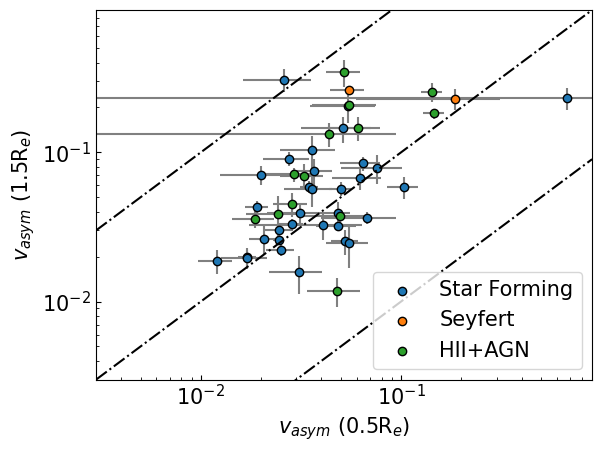

In [46]:
sample = pd.read_csv("MAGPI_csv/kinemetry_sample_M2.csv")
sample = sample[sample["v_asym_15re_err"]<0.1]
bpt = pd.read_csv("MAGPI_csv/kinemetry_sample_M2_BPT.csv")
bpt = bpt[bpt["MAGPIID"].isin(sample['MAGPIID'])]
sf = sample[sample["MAGPIID"].isin(bpt[bpt["type(sf+AGN=0, sf=1, sy=2, ln=3)"]==1]["MAGPIID"])]
sy = sample[sample["MAGPIID"].isin(bpt[bpt["type(sf+AGN=0, sf=1, sy=2, ln=3)"]==2]["MAGPIID"])]
comp = sample[sample["MAGPIID"].isin(bpt[bpt["type(sf+AGN=0, sf=1, sy=2, ln=3)"]==0]["MAGPIID"])]
plt.rcParams.update({"font.size":15})
fig,ax = plt.subplots()
ax.scatter(sf["v_asym_05re"],sf["v_asym_15re"],ec="k",label="Star Forming",zorder=2)
ax.errorbar(sf["v_asym_05re"],sf["v_asym_15re"],yerr=sf["v_asym_15re_err"],xerr=sf['v_asym_05re_err'],ls='',color="grey",zorder=1)
ax.scatter(sy["v_asym_05re"],sy["v_asym_15re"],ec="k", label="Seyfert",zorder=2)
ax.errorbar(sy["v_asym_05re"],sy["v_asym_15re"],yerr=sy["v_asym_15re_err"],xerr=sy['v_asym_05re_err'],ls='',color="grey",zorder=1)
ax.scatter(comp["v_asym_05re"],comp["v_asym_15re"],ec="k",label="HII+AGN",zorder=2)
ax.errorbar(comp["v_asym_05re"],comp["v_asym_15re"],yerr=comp["v_asym_15re_err"],xerr=comp['v_asym_05re_err'],ls='',color="grey",zorder=1)
ax.plot(np.linspace(3e-3,9e-1),np.linspace(3e-3,9e-1),color="k",ls="dashdot")
ax.plot(np.linspace(3e-3,9e-1),10*np.linspace(3e-3,9e-1),color="k",ls="dashdot")
ax.plot(np.linspace(3e-3,9e-1),0.1*np.linspace(3e-3,9e-1),color="k",ls="dashdot")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(3e-3,9e-1)
ax.set_ylim(3e-3,9e-1)
ax.legend(loc="lower right")
ax.set_ylabel(r"$v_{asym}$ (1.5R$_e$)")
ax.set_xlabel(r"$v_{asym}$ (0.5R$_e$)")
plt.savefig("plots/paper1/v_asym_re_AGN.pdf",bbox_inches="tight")